# Building a Convolutional Neural Network (CNN) for emotion recognition with TensorFlow Eager 
----

One of my favourite parts about deep learning is that I can work on problems where I can test the neural networks on myself. The most entertaining neural network that I've built so far is a CNN for emotion recognition. I've managed to pass my webcam video through the network and got predictions of my emotions ~real-time (using a GTX-1070). Quite addictive hehe :)!

Thus, if you would like to combine work with fun, you should definitely go through this tutorial.
Plus, it is a great way to get familiar with the Eager API :)!

### This tutorial consists of the following steps:
___
* _Download and process the FER2013 dataset available on Kaggle._
* _Exploratory data analysis on the entire dataset._
* _Split the dataset into a train and dev dataset._
* _Normalize images._
* _Using the tf.data.Dataset API to iterate through train and dev dataset._
* _Creating a class for a CNN in Eager mode._
    * _Track layers to save the variables from a previous checkpoint._
* _Create a loss function, an optimizer and a function to compute gradients._
* _Train the model with gradient descent._
    * _Whether from scratch or start with a pre-trained model._
* _Visualize the performance during training and compute the accuracy._
* _Visualize the CNN attribution on sample images using Integrated Gradients._
* _Testing the CNN on new images using OpenCV and the Haar Cascades algorithm._


## Import useful libraries
----

In [2]:
# Import libraries for data visualization and processing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Import TensorFlow and TensorFlow Eager
import tensorflow as tf
import tensorflow.contrib.eager as tfe

# Make the plots appear inline in the notebook
%matplotlib inline

In [3]:
# Enable eager mode. Once activated it cannot be reversed! Run just once.
tfe.enable_eager_execution()

## Download dataset 
----
To train our CNN, we will use the FER2013 dataset, available on Kaggle. You have to download the dataset yourself, on their platform, as unfortunately I cannot share the data publicly. Nevertheless, the dataset has only 96.4 MB so you should be able to download it in no time. You can download it [here](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data).

Once you have downloaded the data, unzip it and place it into a folder called 'datasets', so you do not have to make any modifications on the code below.

Okay, so let's get started with the exploratory data analysis :)!

## Exploratory data analysis
----
Before building any machine learning model, it is recommended to do an exploratory data analysis on your dataset. This gives you the opportunity to find any weaknesses in the dataset like strong imbalance between classes, low quality images etc. 

I find that most of the bugs that occur in a machine learning project are due to incorrect data processing. It will be much harder to find these errors if you start investigating the dataset only after you find that your model is not working. 

So, my advice to you is: always analyse the data before building any model :).

In [4]:
# Read input data. Assuming you've unzipped the dataset and put it into a folder named 'data'
path_data = 'datasets/fer2013/fer2013.csv'
data = pd.read_csv(path_data)

In [5]:
print('Number of samples in the dataset: ', data.shape[0])

Number of samples in the dataset:  35887


In [6]:
# See first 5 rows
data.head(5)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [7]:
# Get the meaning of each emotion index
emotion_cat = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}

# See the target distribution (check for imbalance)
target_counts = data['emotion'].value_counts().reset_index(drop=False)
target_counts.columns = ['emotion', 'number_samples']
target_counts['emotion'] = target_counts['emotion'].map(emotion_cat)
target_counts

,emotion,number_samples
0,Happy,8989
1,Neutral,6198
2,Sad,6077
3,Fear,5121
4,Angry,4953
5,Surprise,4002
6,Disgust,547


As you can see, the dataset is quite imbalanced. Especially for the emotion 'Disgust'. This will make the training harder for this class, as the network will have less oportunities to learn the representation of this type of emotion. 

We will see if this will severely impact the training of our network, a bit later, after we've trained our network.

Let's see some images!

The images are currenty represented as a string of integers, each integer representing the intensity of one pixel. We will process the string to be represented as a list of integers.

In [8]:
# Transform images from strings to lists of integers
data['pixels'] = data['pixels'].apply(lambda x: [int(pixel) for pixel in x.split()])

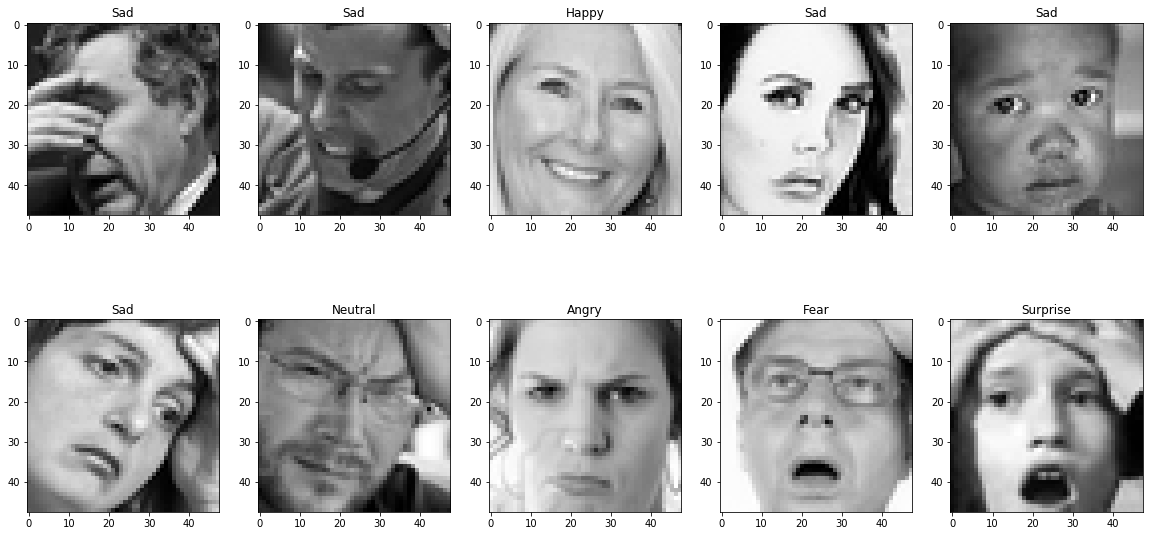

In [9]:
# Change seed here to see other images
random_seed = 2

# Select randomly 10 images
data_sample = data.sample(10, random_state=random_seed)

# Create subplots for images
f, axarr = plt.subplots(2, 5, figsize=(20, 10))

# Plot images
i, j = 0, 0
for idx, row in data_sample.iterrows():
    img = np.array(row['pixels']).reshape(48,48)
    axarr[i,j].imshow(img, cmap='gray')
    axarr[i,j].set_title(emotion_cat[row['emotion']])
    if j==4:
        i += 1
        j = 0
    else:
        j += 1

## Split  dataset in train/dev datasets and normalize images by max
----

In [10]:
data_train = data[data['Usage']=='Training']
size_train = data_train.shape[0]
print('Number samples in the training dataset: ', size_train)

data_dev = data[data['Usage']!='Training']
size_dev = data_dev.shape[0]
print('Number samples in the development dataset: ', size_dev)

Number samples in the training dataset:  28709
Number samples in the development dataset:  7178


In [11]:
# Retrieve train input and target
X_train, y_train = data_train['pixels'].tolist(), data_train['emotion'].as_matrix()
# Reshape images to 4D (num_samples, width, height, num_channels)
X_train = np.array(X_train, dtype='float32').reshape(-1,48,48,1)
# Normalize images with max (the maximum pixel intensity is 255)
X_train = X_train/255.0

# Retrieve dev input and target
X_dev, y_dev = data_dev['pixels'].tolist(), data_dev['emotion'].as_matrix()
# Reshape images to 4D (num_samples, width, height, num_channels)
X_dev = np.array(X_dev, dtype='float32').reshape(-1,48,48,1)
# Normalize images with max
X_dev = X_dev/255.0

## Using the tf.data.Dataset API
----

To prepare our dataset to be used as an input to the CNN, we will use the tf.data.Dataset API which will convert the numpy arrays we've just created, to TF tensors. As this dataset is much bigger than the datasets in the previous tutorials, we will actually have to feed the data to the model in batches.

Normally, for computational efficiency, you would choose a batch as big as you can fit into memory. However, in my experience, I obtain better results on test data, if I use smaller batches. Feel free to play with the batch size and see if you get to the same conclusion as I did.

In [12]:
# Feel free to modify the size of the batches
# Usually smaller batch sizes obtain better results on test data
batch_size = 64
training_data = tf.data.Dataset.from_tensor_slices((X_train, y_train[:,None])).batch(batch_size)
eval_data = tf.data.Dataset.from_tensor_slices((X_dev, y_dev[:,None])).batch(batch_size)

## Create CNN model in Eager mode
----

The CNN architecture is created in the cell below. As you can see, the class _EmotionRecognitionCNN_ inherits from _tf.keras.Model_ class as we want to track the layers that contain any trainable parameters (e.g. the weights of a convolution, the mean of a batch normalization layer). This makes it extremely easy to save these variables and then restore them at a later time when we want to continue training the network. 

The original architecture of this CNN can be found [here](https://github.com/oarriaga/face_classification) (built with keras). I thought that it will be really useful if you start with a simpler architecture than ResNet for example. This network turns out to work pretty well for its size. 

You can play with it, add more layers, increase the number of layers, filters etc. See if you can obtain better results.

One thing that is sure, is that the network works better with higher dropout.

In [13]:
class EmotionRecognitionCNN(tf.keras.Model):
    
    def __init__(self, num_classes, device='cpu:0', checkpoint_directory=None):
        ''' Define the parameterized layers used during forward-pass, the device
            where you would like to run the computation on, and the checkpoint
            directory.
            
            Args:
                num_classes: the number of classes in the output of the network.
                             optimizer: the optimizer selected for training the network.
                device: string, 'cpu:n' or 'gpu:n' (n can vary). Default, 'cpu:0'.
                checkpoint_directory: the directory where you would like to save/ restore
                                      a model.
        ''' 
        super(EmotionRecognitionCNN, self).__init__()
        
        # Initialize layers
        self.conv1 = tf.layers.Conv2D(16, 5, padding='same', activation=None)
        self.batch1 = tf.layers.BatchNormalization()
        self.conv2 = tf.layers.Conv2D(16, 5, 2, padding='same', activation=None)
        self.batch2 = tf.layers.BatchNormalization()
        self.conv3 = tf.layers.Conv2D(32, 5, padding='same', activation=None)
        self.batch3 = tf.layers.BatchNormalization()
        self.conv4 = tf.layers.Conv2D(32, 5, 2, padding='same', activation=None)
        self.batch4 = tf.layers.BatchNormalization()
        self.conv5 = tf.layers.Conv2D(64, 3, padding='same', activation=None)
        self.batch5 = tf.layers.BatchNormalization()
        self.conv6 = tf.layers.Conv2D(64, 3, 2, padding='same', activation=None)
        self.batch6 = tf.layers.BatchNormalization()
        self.conv7 = tf.layers.Conv2D(64, 1, padding='same', activation=None)
        self.batch7 = tf.layers.BatchNormalization()
        self.conv8 = tf.layers.Conv2D(128, 3, 2, padding='same', activation=None)
        self.batch8 = tf.keras.layers.BatchNormalization()
        self.conv9 = tf.layers.Conv2D(256, 1, padding='same', activation=None)
        self.batch9 = tf.keras.layers.BatchNormalization()
        self.conv10 = tf.layers.Conv2D(128, 3, 2, padding='same', activation=None)
        self.conv11 = tf.layers.Conv2D(256, 1, padding='same', activation=None)
        self.batch11 = tf.layers.BatchNormalization()
        self.conv12 = tf.layers.Conv2D(num_classes, 3, 2, padding='same', activation=None)
        
        # Define the device 
        self.device = device
        
        # Define the checkpoint directory
        self.checkpoint_directory = checkpoint_directory
       
    def predict(self, images, training):
        """ Predicts the probability of each class, based on the input sample.
            
            Args:
                images: 4D tensor. Either an image or a batch of images.
                training: Boolean. Either the network is predicting in
                          training mode or not.
        """
        x = self.conv1(images)
        x = self.batch1(x, training=training)
        x = self.conv2(x)
        x = self.batch2(x, training=training)
        x = tf.nn.relu(x)
        x = tf.layers.dropout(x, rate=0.4, training=training)
        x = self.conv3(x)
        x = self.batch3(x, training=training)
        x = self.conv4(x)
        x = self.batch4(x, training=training)
        x = tf.nn.relu(x)
        x = tf.layers.dropout(x, rate=0.3, training=training)
        x = self.conv5(x)
        x = self.batch5(x, training=training)
        x = self.conv6(x)
        x = self.batch6(x, training=training)
        x = tf.nn.relu(x)
        x = tf.layers.dropout(x, rate=0.3, training=training)
        x = self.conv7(x)
        x = self.batch7(x, training=training)
        x = self.conv8(x)
        x = self.batch8(x, training=training)
        x = tf.nn.relu(x)
        x = tf.layers.dropout(x, rate=0.3, training=training)
        x = self.conv9(x)
        x = self.batch9(x, training=training)
        x = self.conv10(x)
        x = self.conv11(x)
        x = self.batch11(x, training=training)
        x = self.conv12(x)
        return tf.layers.flatten(x)
    
    def loss_fn(self, images, target, training):
        """ Defines the loss function used during 
            training.         
        """
        preds = self.predict(images, training)
        loss = tf.losses.sparse_softmax_cross_entropy(labels=target, logits=preds)
        return loss
    
    def grads_fn(self, images, target, training):
        """ Dynamically computes the gradients of the loss value
            with respect to the parameters of the model, in each
            forward pass.
        """
        with tfe.GradientTape() as tape:
            loss = self.loss_fn(images, target, training)
        return tape.gradient(loss, self.variables)
    
    def restore_model(self):
        """ Function to restore trained model.
        """
        with tf.device(self.device):
            # Run the model once to initialize variables
            dummy_input = tf.constant(tf.zeros((1,48,48,1)))
            dummy_pred = self.predict(dummy_input, training=False)
            # Restore the variables of the model
            saver = tfe.Saver(self.variables)
            saver.restore(tf.train.latest_checkpoint
                          (self.checkpoint_directory))
    
    def save_model(self):
        """ Function to save trained model.
        """
        tfe.Saver(self.variables).save(checkpoint_directory, global_step=0)   
    
    def compute_accuracy(self, input_data):
        """ Compute the accuracy on the input data.
        """
        with tf.device(self.device):
            acc = tfe.metrics.Accuracy()
            for images, targets in tfe.Iterator(input_data):
                # Predict the probabilities of each class
                logits = self.predict(images, training=False)
                # Select the class with the highest probability
                preds = tf.argmax(logits, axis=1)
                # Compute the accuracy
                acc(tf.reshape(targets, [-1,]), preds)
        return acc
        
    def fit(self, training_data, eval_data, optimizer, num_epochs=500, 
            early_stopping_rounds=10, verbose=10, train_from_scratch=False):
        """ Function to train the model, using the selected optimizer and
            for the desired number of epochs. You can either train from scratch
            or load the latest model trained. Early stopping is used in order to
            mitigate the risk of overfitting the network.
            
            Args:
                training_data: the data you would like to train the model on.
                                Must be in the tf.data.Dataset format.
                eval_data: the data you would like to evaluate the model on.
                            Must be in the tf.data.Dataset format.
                optimizer: the optimizer used during training.
                num_epochs: the number of iterations for training the model.
                early_stopping_rounds: stop training if the loss on the eval 
                                       dataset does not decrease after n epochs.
        """ 
        
        if train_from_scratch==False:
            self.restore_model()
        
        # Initialize best loss. This variable will store the lowest loss on the
        # eval dataset.
        best_loss = 999
        
        # Initialize classes to update the mean loss of train and eval
        train_loss = tfe.metrics.Mean('train_loss')
        eval_loss = tfe.metrics.Mean('eval_loss')
        
        # Initialize dictionary to store the loss history
        self.history = {}
        self.history['train_loss'] = []
        self.history['eval_loss'] = []
        
        # Begin training
        with tf.device(self.device):
            for i in range(num_epochs):
                # Training with gradient descent
                for images, target in tfe.Iterator(training_data):
                    grads = self.grads_fn(images, target, True)
                    optimizer.apply_gradients(zip(grads, self.variables))
                    
                # Compute the loss on the training data after one epoch
                for images, target in tfe.Iterator(training_data):
                    loss = self.loss_fn(images, target, False)
                    train_loss(loss)
                self.history['train_loss'].append(train_loss.result().numpy())
                # Reset metrics
                train_loss.init_variables()
                
                # Compute the loss on the eval data after one epoch
                for images, target in tfe.Iterator(eval_data):
                    loss = self.loss_fn(images, target, False)
                    eval_loss(loss)
                self.history['eval_loss'].append(eval_loss.result().numpy())
                # Reset metrics
                eval_loss.init_variables()
                
                # Print train and eval losses
                if (i==0) | ((i+1)%verbose==0):
                    print('Train loss at epoch %d: ' %(i+1), self.history['train_loss'][-1])
                    print('Eval loss at epoch %d: ' %(i+1), self.history['eval_loss'][-1])

                # Check for early stopping
                if self.history['eval_loss'][-1]<best_loss:
                    best_loss = self.history['eval_loss'][-1]
                    count = early_stopping_rounds
                else:
                    count -= 1
                if count==0:
                    break  

## Train the model with gradient descent and early stopping
----

I have saved the variables after training the network for 99 epochs. You can restore them and then fine tune them for a few more epochs. If you do not have a GPU on your computer, I believe it will be better to load the variables that I have trained for. It will be much easier to further tune the model, than starting training the model from scratch.

You can use early stopping to stop training the network, if the loss on the dev dataset does not decrease after _n_ epochs (you can set the number of _n_ with the variable _early_stopping_rounds_).

In [14]:
# Specify the path where you want to save/restore the trained variables.
checkpoint_directory = 'models_checkpoints/EmotionCNN/'

# Use the GPU if available.
device = 'gpu:0' if tfe.num_gpus()>0 else 'cpu:0'

# Define optimizer.
optimizer = tf.train.AdamOptimizer()

# Instantiate model. This doesn't initialize the variables yet.
model = EmotionRecognitionCNN(num_classes=7, device=device, 
                              checkpoint_directory=checkpoint_directory)

In [ ]:
model.fit(training_data, eval_data, optimizer, num_epochs=500, 
          early_stopping_rounds=5, verbose=10, train_from_scratch=True)

Train loss at epoch 1:  1.5994938561539342
Eval loss at epoch 1:  1.6061641948413006


In [17]:
model.save_model()

## Visualize the performance during training
----

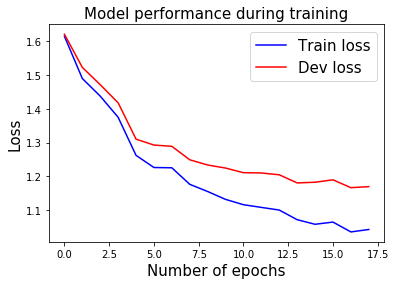

In [19]:
plt.plot(range(len(model.history['train_loss'])), model.history['train_loss'],
         color='b', label='Train loss');
plt.plot(range(len(model.history['eval_loss'])), model.history['eval_loss'], 
         color='r', label='Dev loss');
plt.title('Model performance during training', fontsize=15)
plt.xlabel('Number of epochs', fontsize=15);
plt.ylabel('Loss', fontsize=15);
plt.legend(fontsize=15);

## Compute accuracy
----

In [16]:
train_acc = model.compute_accuracy(training_data)
eval_acc = model.compute_accuracy(eval_data)

In [18]:
print('Train accuracy: ', train_acc.result().numpy())
print('Eval accuracy: ', eval_acc.result().numpy())

Train accuracy:  0.6124560242432686
Eval accuracy:  0.5565617163555308


## Visualize neural network attributions with integrated gradients
----

So now that we have trained our CNN model, let's see if we can understand its reasoning using integrated gradients. This methodology is thoroughly explained in [this paper](https://arxiv.org/abs/1703.01365), called Axiomatic Attribution for Deep Networks.

Normally, the first attempt you would do to understand the predictions of your model is to compute directly the derivative of the output class with respect to the image. This can give you a hint on which part of the image activated the network. However, this technique is sensitive to image artifacts.

To avoid this pitfall we are going to use integrated gradients to compute the attributions of the network for a certain image. This technique simply takes the original image, scales the pixel intensities to various degrees (from $\frac{1}{m}$ to m, where m is the number of steps) and computes the gradient with respect to each scaled image. To obtain the attributions, the gradients of all the scaled images are averaged and multiplied with the original image.

Here is an example of how you would implement this in TensorFlow Eager:

In [19]:
def get_prob_class(X, idx_class):
    """ Gets the softmax probability of the selected class.
        
        Args:
            X: 4D tensor image.
            
        Returns:
            prob_class: the probability of the selected class.  
    """
    logits = model.predict(X, False)
    prob_class = logits[0, idx_class]
    return prob_class

In [20]:
def integrated_gradients(X, m=200):
    """ Computes the integrated gradients for an image sample.
        
        Args:
            X: 4D tensor of the image sample.
            m: number of steps, more steps leads to a better approximation.
               
        Returns:
            g: integrated gradients.
    """
    perc = (np.arange(1,m+1)/m).reshape(m,1,1,1)
    perc = tf.constant(perc, dtype=tf.float32)
    idx_class = tf.argmax(model.predict(X, False), axis=1).numpy()[0]
    X_tiled = tf.tile(X, [m,1,1,1])
    X_scaled = tf.multiply(X_tiled, perc)
    grad_fn = tfe.gradients_function(get_prob_class, params=[0])
    g = grad_fn(X_scaled, idx_class)
    g = tf.reduce_mean(g, axis=[1])
    g = tf.multiply(X, g)
    return g, idx_class

In [21]:
def visualize_attributions(X, g, idx_class):
    """ Function to plot the original image along with the CNN attributions using
        integrated gradients.
        
        Args:
            X: 4D tensor image.
            g: integrated gradients.
            idx_class: the index of the predicted label.
    """
    img_attributions = X*tf.abs(g)
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    ax1.imshow(X[0,:,:,0], cmap='gray')
    ax1.set_title('Predicted emotion: %s' %emotion_cat[idx_class], fontsize=15)
    ax2.imshow(img_attributions[0,:,:,0], cmap='gray')
    ax2.set_title('Integrated gradients', fontsize=15)
    plt.tight_layout()

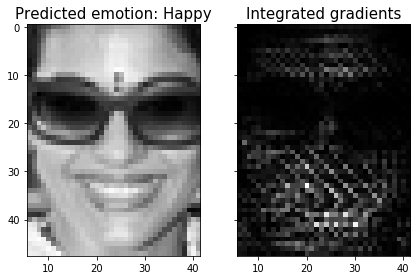

In [22]:
with tf.device(device):
    idx_img = 1600 # modify here to change the image
    X = tf.constant(X_train[idx_img,:].reshape(1,48,48,1))
    g, idx_class = integrated_gradients(X, m=200)
    visualize_attributions(X, g, idx_class)

**The brighter parts of the integrated gradients image have the most influence on the predicted label.**

## Webcam  testing
----

Finally, you can test the performance of your CNN on any new set of images or videos. In the cell bellow, I show you how you can use your webcam to capture image frames and make predictions on them.

To be able to do this you would have to install the library **opencv-python**. You can easily do this by typing in the terminal:

> **pip install opencv-python**

As you have seen in the beginning of the notebook, the images in the FER2013 dataset have already the faces cropped. In order to crop the faces in the new images/videos, we will be using the pre-trained Haar-Cascade algorithm, found in the **OpenCV** library.

So, let's get started!

If you want to run the model on live webcam footage use:
> **cap = cv2.VideoCapture(0)**

If you have a pre-recorded video you would like to test, you can use:
> **cap = cv2.VideoCapture(path_video)**

Feel free to try the network on yourself! I guarantee that it's going to be a lot of fun :).

In [23]:
# Import OpenCV
import cv2

# Create font for adding text to images
font = cv2.FONT_HERSHEY_SIMPLEX

In [24]:
# Import pre-trained Haar-Cascade algorithm for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

The code for webcam capture has been inspired from [this tutorial](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_gui/py_video_display/py_video_display.html).

In [ ]:
# Open video capture
cap = cv2.VideoCapture(0)

# Uncomment if you want to save the video along with its predictions
# fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
# out = cv2.VideoWriter('test_cnn.mp4', fourcc, 20.0, (720,480))

while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()
   
    # Transfrom RGB frame to gray scale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Detect all the faces in the frame
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    
    # Iterate through each face found
    for (x,y,w,h) in faces:
        # Crop the face from the grayscale frame
        face_gray = gray[y:y+h, x:x+w]    
        # Resize images to 48x48 pixels
        face_res = cv2.resize(face_gray, (48,48)) 
        face_res = face_res.reshape(1,48,48,1)
        # Normalize image by max
        face_norm = face_res/255.0
        # Forward-pass through the model
        with tf.device(device):
            X = tf.constant(face_norm)
            X = tf.cast(X, tf.float32)
            logits = model.predict(X, False)
            probs = tf.nn.softmax(logits)
            ordered_classes = np.argsort(probs[0])[::-1]
            ordered_probs = np.sort(probs[0])[::-1]
            k = 0
            # Draw the probabilities for each prediction, on the frame
            for cl, prob in zip(ordered_classes, ordered_probs):
                # Add rectangle with width proportional to its probability
                cv2.rectangle(frame, (20,100+k),(20+int(prob*100),130+k),(170,145,82),-1)
                # Add the emotion label to the rectangle drawn
                cv2.putText(frame,emotion_cat[cl],(20,120+k),font,1,(0,0,0),1,cv2.LINE_AA)
                k += 40
    
    # Uncomment if you wish to write this video to disk
    #out.write(frame)
    
    # Display the resulting frame
    cv2.imshow('frame',frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
   

In [26]:
# When everything is done, release the capture
cap.release()
cv2.destroyAllWindows()